# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS25: Computer Vision 

## Final Project: Automatic category identification and filter mapping for Products
### (Focus: Fashion Ecommerce Categories)


**Harvard University**<br/>
**Spring 2022**<br/>
**Instructor**: Stephen Elston<br/>
**Submitted By**: Sahil Sakhuja<br/>

<hr style="height:2pt">

<div class="alert alert-block alert-success">

# Introduction
<br />  
    
</div>

### Introduction

In e-commerce portals, we have thousands, if not millions, of products. With a view to tackle reducing attention spans of customers and lower exclusivity in product portfolios, the capability to have improved searchability within the catalogue is a critical desired outcome for companies operating in this space.

There are primarily two ways that consumers search for products in any e-commerce portal, namely:

1.	Using the Search option which performs a free-text search in the names and descriptions of the products
1.	Traversing through the categories and sub-categories on the website and then using provided Filters to restrict the number of displayed items

In this project, I would like to focus on improving results for the 2nd route i.e. creating an automated model to help e-commerce site owners & administrators to maximize accuracy of categorization and filtering.
Categorization and filtering of products is based on inputs made into a cataloguing system. This creates 2 points of failures:

1. Incorrect or insufficient category mapping primarily due to:
    1. Manual blunders: Men’s trousers categories under Women’s trousers
    1. Insufficient breadth: A pair of unisex shoes only categorized under Men’s shoes
    1. Insufficient depth: A pair of Sneakers only categorized into the top category as shoes and not sub-categorized as Sneakers
1. Insufficient data input for filters eg. Collar type not updated on a Shirt

These issues would lead to inefficiencies in product search by customers.

### Project Goal

I would like to focus my project on developing a model which can, given an image, be able to recommend the right category / sub-category for a product as well as recommend the relevant filter options to be enabled for the product and the value thereof. To limit the scope, I am focusing the project only on the Fashion category.

Hence, I will be training ML models for 2 distinct outcomes:

1. **Goal 1**: Recommendation of a category for the product in the image.
1. **Goal 2**: Recommend different filters, and the respective values thereof, for the product in the image.

### Importing various libraries

In [79]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.metrics import f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

from skimage.color import rgb2gray
from sklearn.feature_selection import VarianceThreshold

In [59]:
sns.set_theme(style='white', palette='pastel', font_scale=1.1)

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy

from keras.preprocessing import dataset_utils
from keras.preprocessing import image_dataset

# !pip install tensorflow-addons
import tensorflow_addons as tfa

In [4]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Autotune Value = {AUTOTUNE}")

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Autotune Value = -1


### Setting variables and file paths

In [88]:
hnm_file_format = 'data/HnM_{}.parquet'
# hnm_img_final = 'images/HnM/'
hnm_img_resized = 'images_resized/HnM/'

cna_file_format = 'data/CnA_{}.parquet'
cna_img_resized = 'images_test_resized/CnA_'

In [5]:
model_wts_path = 'model_data/'
model_hist_path = 'model_data/'

<div class="alert alert-block alert-success">

# EDA
<br />  
    
</div>

I have used web-scraping to fetch the data from a prominent Fashion e-commerce portal in Germany and have extracted the following artefacts:

1. Images – only “still-life” images i.e. images which are of the product itself and do not include any models.
1. Category / Sub-Category – The category and sub-category that those products are currently tagged in. These are the “true labels”.
1. Filters and Filter Values – the attributes of the product which are available as filters on the images and the values thereof. These are the “true labels”.

The data is stored as follows:
1. 4 files with relevant data and mappings, namely:
    1. Categories: Dataframe with information on category mappings i.e. main categories (Men, Women, Baby and Kids) and sub-categories within these (eg. Shirts, Trousers, Dresses, etc.).
    1. Items: Dataframe with information on each item listed on the e-commerce portal (snapshot as on 12th / 13th / 14th March, 2022) with details including: Item code, Category Id, Image URL, Image Extension, etc.
    1. Filters: Dataframe containing information on filters available in each sub-category eg. Colour, Pattern, Sleeve Length, etc.
    1. Filter Values: Dataframe containing the Item code, the fitler Id and the value of the Filter for that item.

1. Images of each item – named in the format {Portal_Name}_{Item_Code}.{Extension}.


### Reading all the data files

In [49]:
cats = pd.read_parquet(hnm_file_format.format('Categories'))
filters = pd.read_parquet(hnm_file_format.format('Filters'))
items = pd.read_parquet(hnm_file_format.format('Items'))
attributes = pd.read_parquet(hnm_file_format.format('FilterAttributes'))

### Starting EDA on categories and items

In [50]:
cats.head()

,Category,URL,Parent_Category,Top_Category,Skip
0,Shirts & Tops,/de_de/damen/produkte/tops.html,NaN,Women,False
1,Basics,/de_de/damen/produkte/basics.html,NaN,Women,False
2,Hemden & Blusen,/de_de/damen/produkte/hemden-blusen.html,NaN,Women,False
3,Cardigans & Pullover,/de_de/damen/produkte/cardigans-pullover.html,NaN,Women,False
4,Strickwaren,/de_de/damen/produkte/strickwaren.html,NaN,Women,False


In [51]:
# check items per parent category
# join parent categories into items
items.head()

,Code,Name,URL,Img_URL,Img_Ext,Category
0,1071498001,Cut-out-Shirt,/de_de/productpage.1071498001.html,//lp2.hm.com/hmgoepprod?set=source[/a2/90/a290...,.jpg,29.0
1,1069183001,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183001.html,//lp2.hm.com/hmgoepprod?set=source[/12/09/1209...,.jpg,29.0
2,0985757001,Kurzshirt mit Cut-out,/de_de/productpage.0985757001.html,//lp2.hm.com/hmgoepprod?set=source[/68/a3/68a3...,.jpg,29.0
3,0985757002,Kurzshirt mit Cut-out,/de_de/productpage.0985757002.html,//lp2.hm.com/hmgoepprod?set=source[/10/22/1022...,.jpg,29.0
4,1069183002,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183002.html,//lp2.hm.com/hmgoepprod?set=source[/d1/3a/d13a...,.jpg,29.0


In [52]:
cats[(cats['Parent_Category'].isna()) & (cats['Skip'] == False)].groupby(['Top_Category'])['Category'].count().reset_index()

,Top_Category,Category
0,Baby,5
1,Kids,6
2,Men,18
3,Women,23


#### Adding category information into the dataframe of items

In [53]:
# adding top category name and parent category id
items = items.merge(
    cats[['Category', 'Parent_Category', 'Top_Category']], 
    how='left', 
    left_on='Category', 
    right_index=True
).drop(
    columns='Category_y'
).rename(
    columns={
        'Category_x': 'Category'
    }
)

In [54]:
items.head()

,Code,Name,URL,Img_URL,Img_Ext,Category,Parent_Category,Top_Category
0,1071498001,Cut-out-Shirt,/de_de/productpage.1071498001.html,//lp2.hm.com/hmgoepprod?set=source[/a2/90/a290...,.jpg,29.0,0.0,Women
1,1069183001,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183001.html,//lp2.hm.com/hmgoepprod?set=source[/12/09/1209...,.jpg,29.0,0.0,Women
2,0985757001,Kurzshirt mit Cut-out,/de_de/productpage.0985757001.html,//lp2.hm.com/hmgoepprod?set=source[/68/a3/68a3...,.jpg,29.0,0.0,Women
3,0985757002,Kurzshirt mit Cut-out,/de_de/productpage.0985757002.html,//lp2.hm.com/hmgoepprod?set=source[/10/22/1022...,.jpg,29.0,0.0,Women
4,1069183002,Kurzes Shirt mit Cut-out,/de_de/productpage.1069183002.html,//lp2.hm.com/hmgoepprod?set=source[/d1/3a/d13a...,.jpg,29.0,0.0,Women


In [55]:
# adding name of parent category also
items = items.merge(
    cats[['Category', 'Parent_Category']], 
    left_on='Parent_Category', 
    right_index=True, 
    how='left'
).rename(
    columns={
        'Category_x': 'Category',
        'Category_y': 'Parent_Category_Name',
        'Parent_Category_x': 'Parent_Category'
}
).drop(
    columns='Parent_Category_y'
)

In [73]:
print(f"The data consists of {items['Code'].nunique():,} images.")

The data consists of 16,473 images.


#### Items are split into 4 top categories: Baby, Kids, Men and Women

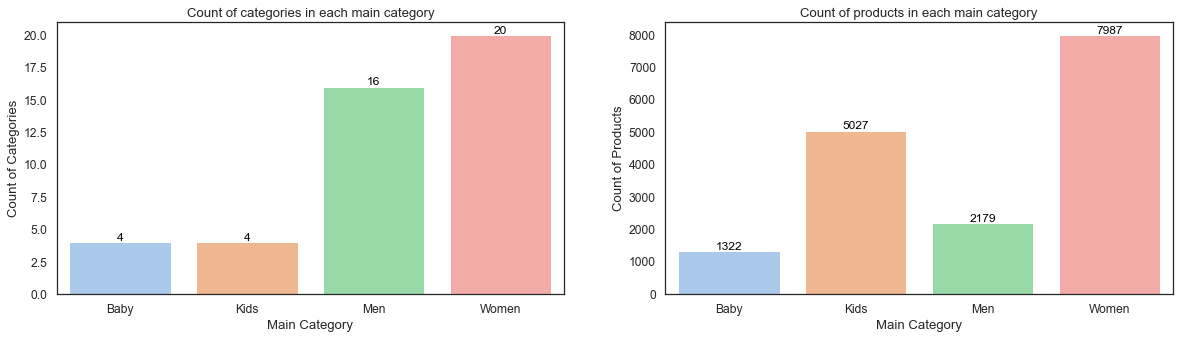

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)

sns.barplot(
    data=items.groupby('Top_Category')['Parent_Category_Name'].nunique().reset_index(),
    x='Top_Category',
    y='Parent_Category_Name',
    ax=axes[0]
)
axes[0].set(
    xlabel = 'Main Category',
    ylabel = 'Count of Categories',
    title = 'Count of categories in each main category'
)

for p in axes[0].patches:
    axes[0].text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

    
sns.barplot(
    data=items.groupby('Top_Category')['Code'].nunique().reset_index(),
    x='Top_Category',
    y='Code'
)    
axes[1].set(
    xlabel = 'Main Category',
    ylabel = 'Count of Products',
    title = 'Count of products in each main category'
)

for p in axes[1].patches:
    axes[1].text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')


plt.show()

#### Within each category, there are also sub-categories present,

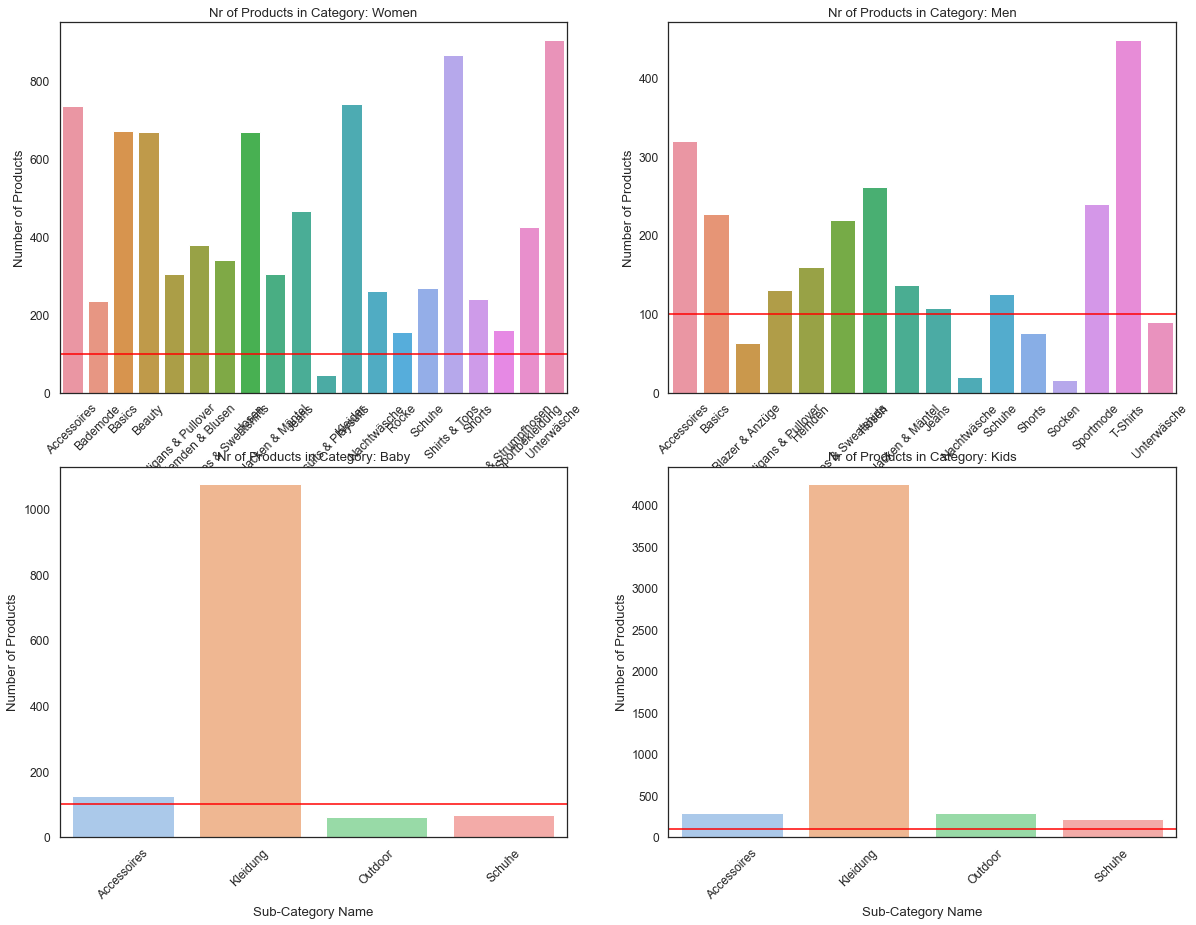

In [63]:
limit = 100

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()

for i, c in enumerate(items['Top_Category'].unique()):
    data = items[items['Top_Category'] == c].groupby('Parent_Category_Name')['Code'].nunique().reset_index().rename(columns={'Code': 'Nr_Of_Products'})
    sns.barplot(
        data = data,
        x = 'Parent_Category_Name',
        y = 'Nr_Of_Products',
        ax=axes[i]
    )
    axes[i].set(
        title = f"Nr of Products in Category: {c}",
        xlabel = "Sub-Category Name",
        ylabel = 'Number of Products',
    )
    axes[i].tick_params(axis='x', labelrotation = 45)
    axes[i].axhline(y=limit, color='red')

plt.show()

<div class="alert alert-block alert-info">

#### Decision
<br />  
I have chosen to only consider sub-categories which have a minimum of 100 products – hence, this translates into a total of 36 categories which can be used as outcome labels. The remaining categories and products within them would not be used for the purpose of the project.
</div>

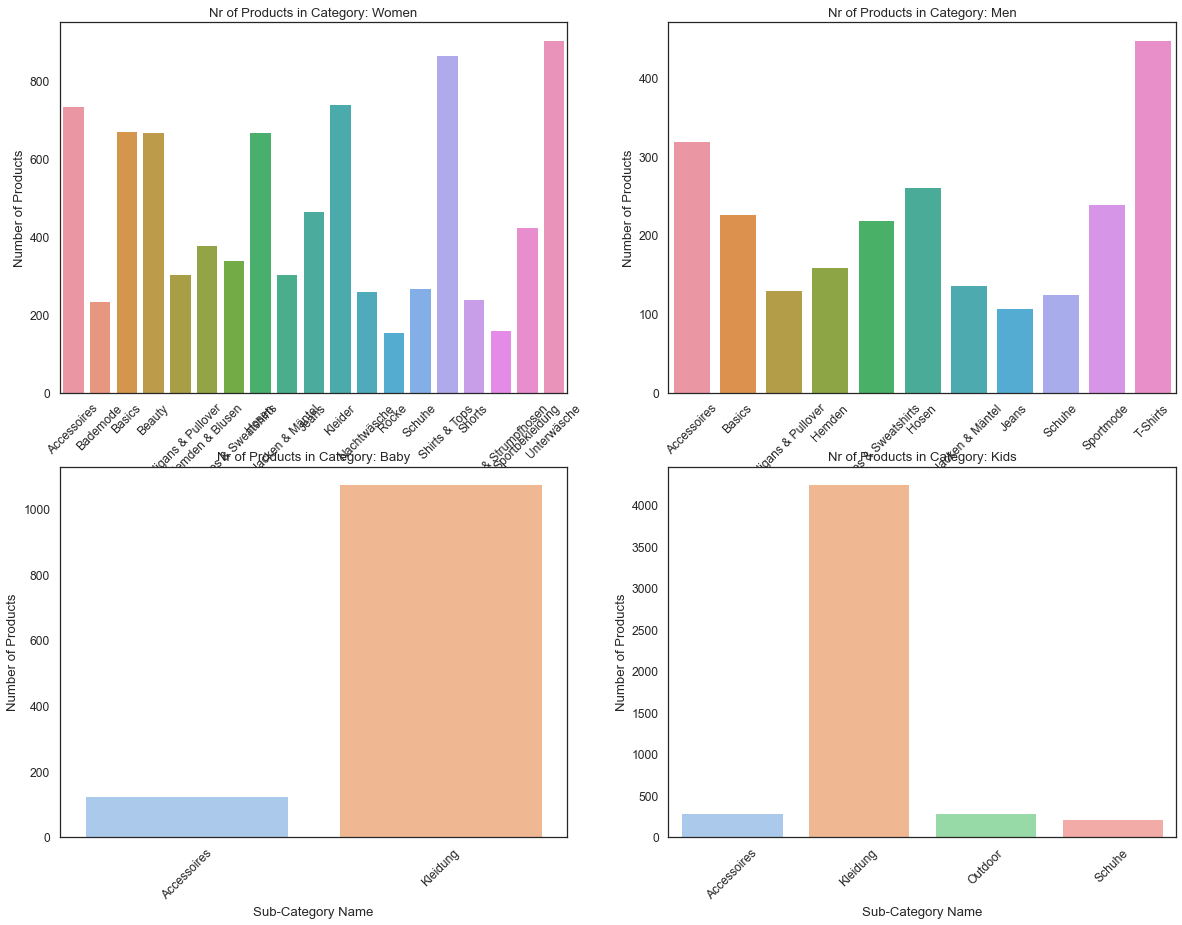

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()

for i, c in enumerate(items['Top_Category'].unique()):
    data = items[items['Top_Category'] == c].groupby('Parent_Category_Name')['Code'].nunique().reset_index().rename(columns={'Code': 'Nr_Of_Products'})
    sns.barplot(
        data = data[data['Nr_Of_Products'] > limit],
        x = 'Parent_Category_Name',
        y = 'Nr_Of_Products',
        ax=axes[i]
    )
    axes[i].set(
        title = f"Nr of Products in Category: {c}",
        xlabel = "Sub-Category Name",
        ylabel = 'Number of Products',
    )
    axes[i].tick_params(axis='x', labelrotation = 45)

plt.show()

In [65]:
d = items.groupby(['Top_Category', 'Parent_Category', 'Parent_Category_Name'])['Code'].nunique().reset_index().rename(columns={'Code': 'Nr_Of_Products'})
print(f"Categories to consider = {d[d['Nr_Of_Products'] > limit].shape[0]}")

Categories to consider = 36


In [66]:
print(d[d['Nr_Of_Products'] > limit]['Parent_Category_Name'].unique())

['Kleidung' 'Accessoires' 'Outdoor' 'Schuhe' 'Jacken & Mäntel'
 'Hoodies & Sweatshirts' 'Cardigans & Pullover' 'Hemden' 'T-Shirts'
 'Hosen' 'Jeans' 'Basics' 'Sportmode' 'Shirts & Tops' 'Hemden & Blusen'
 'Shorts' 'Röcke' 'Kleider' 'Bademode' 'Unterwäsche' 'Nachtwäsche'
 'Socken & Strumpfhosen' 'Sportbekleidung' 'Beauty']


In [68]:
final_cats = d[d['Nr_Of_Products'] > 100]['Parent_Category'].values

In [69]:
final_cats = d[d['Nr_Of_Products'] > 100]['Parent_Category'].values

In [70]:
items['Final_Cat'] = items.apply(lambda row: True if row['Parent_Category'] in final_cats else False, axis=1)

In [74]:
items_final = items[items['Final_Cat']]

### Conducting EDA on filters

There are also various filters available in each category. On an average, each main category has about 15 filters.

Not all items in the dataset have the same number of filters. Each category has a certain amount of filters, for eg. items in the category for "Socks" under the parent category "Women" can have up to 9 filters, however, as can be seen below, the first item has only 4 filters mapped to it and 5 filters have not been mapped to it.

In [76]:
# keeping values only for items of interest
items_attribs = attributes[attributes['Code'].isin(items_final['Code'])]

# joining filter names and values into attribs
items_attribs = items_attribs.merge(filters, how='left', left_on='Filter_ID', right_index=True)

# joining top category and parent category name into attribs df
items_attribs = items_attribs.merge(items_final[['Code', 'Top_Category', 'Parent_Category_Name']], how='left', on='Code')

# seeing unique filter groups
filters_per_cat = items_attribs.groupby(['Parent_Category'])['Filter_Name'].nunique().reset_index()

# looking at unique filters per code
unique_filters = items_attribs.groupby(['Code', 'Top_Category', 'Parent_Category', 'Parent_Category_Name'])['Filter_Name'].nunique().reset_index()

# join back expected filters_per_cat
unique_filters = unique_filters.merge(filters_per_cat, how='left', on='Parent_Category').rename(columns={'Filter_Name_x': 'Nr_Of_Filters', 'Filter_Name_y': 'Total_Filters'})

unique_filters['Missing_Filters'] = unique_filters['Total_Filters'] - unique_filters['Nr_Of_Filters']

unique_filters.head()

,Code,Top_Category,Parent_Category,Parent_Category_Name,Nr_Of_Filters,Total_Filters,Missing_Filters
0,0111565001,Women,19,Socken & Strumpfhosen,4,9,5
1,0111593001,Women,16,Socken & Strumpfhosen,2,5,3
2,0111593001,Women,16,Unterwäsche,2,5,3
3,0111593001,Women,19,Socken & Strumpfhosen,3,9,6
4,0111593001,Women,19,Unterwäsche,3,9,6


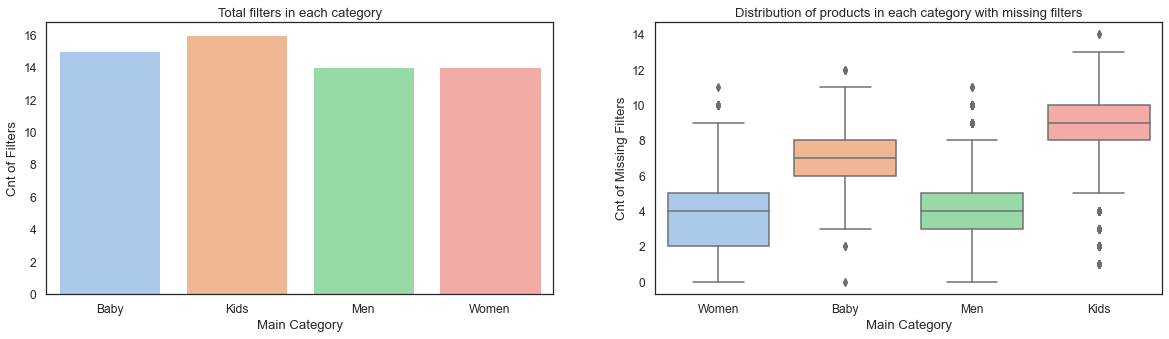

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

sns.barplot(
    data=unique_filters.groupby('Top_Category')['Total_Filters'].max().reset_index(), 
    x='Top_Category', 
    y='Total_Filters',
    ax=axes[0]
)
axes[0].set(
    xlabel = 'Main Category',
    ylabel = 'Cnt of Filters',
    title = 'Total filters in each category'
)


sns.boxplot(data=unique_filters, x='Top_Category', y='Missing_Filters', ax=axes[1])
axes[1].set(
    xlabel = 'Main Category',
    ylabel = 'Cnt of Missing Filters',
    title = 'Distribution of products in each category with missing filters'
)

plt.show()

### EDA on Images

All images are of the size 453X302 with 3 colour channels. As part of the web scraping, I have been able to get images which are “still life” i.e. there are no models in the images and hence, they are directly usable for the purpose of the project.

Some example images:

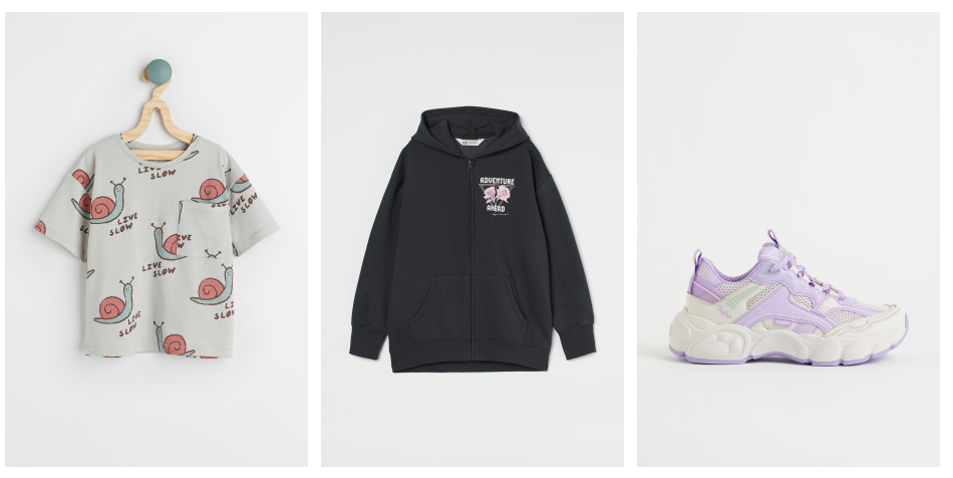

In [91]:
# read a few images
imgs = []
i = 0
for idx, row in items_final.iterrows():
    filename = f"{hnm_img_resized}{row['Code']}{row['Img_Ext']}"
    if not os.path.exists(filename):
        continue
    imgs.append(rgb2gray(plt.imread(filename)).reshape(-1))
    i += 1
    if i >= 512:
        break

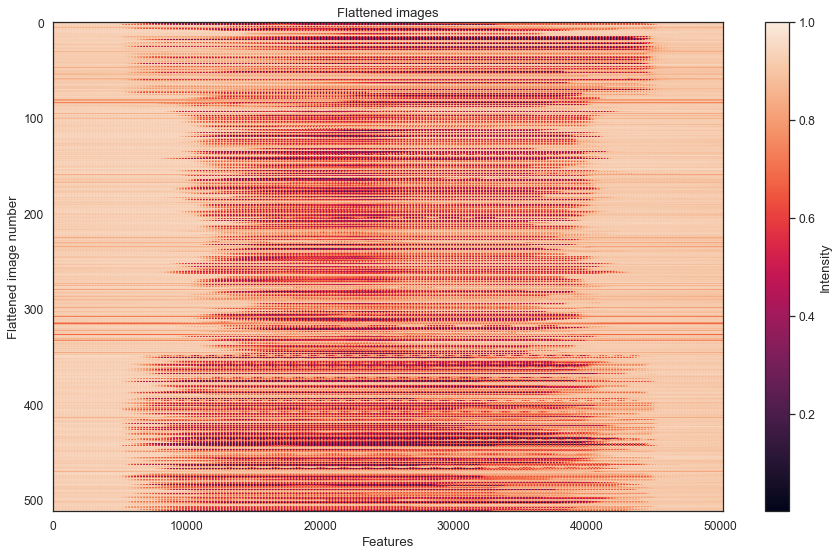

In [92]:
def plot_feature_sample(img, nrows=512):
    fig, ax = plt.subplots(figsize=(15,9))
    p = ax.imshow(img[:nrows], aspect='auto')
    plt.ylabel('Flattened image number')
    plt.xlabel('Features')
    plt.title('Flattened images')
    cb = plt.colorbar(p)
    _=cb.set_label('Intensity')
    
plot_feature_sample(imgs)

<div class="alert alert-block alert-info">

#### Decision
<br />  
While there are borders in the images, I have chosen not to remove them using techniques like Variance Thresholding. My reasons for this decision are as follows:
    
1. Since I will be using transfer learning from pre-trained Keras Applications, the expectation is that this will be automatically managed by the convolutional kernels.
1. Having explored a lot of images, I have seen instances where the objects of interest in the images also do not have a lot of variation in them and setting a variance threshold manually might lead to incorrect inputs for these items.
</div>

<div class="alert alert-block alert-success">

# Data Preparation for Modeling
<br />  
    
</div>

### Data prep for Goal 1: Model Training for Category Prediction

For the purpose of category prediction, the required information is available in 2 files, namely:

1. Categories: Dataframe with information on category mappings i.e. main categories (Men, Women, Baby and Kids) and sub-categories within these (eg. Shirts, Trousers, Dresses, etc.).
1. Items: Dataframe with information on each item listed on the e-commerce portal (snapshot as on 12th / 13th / 14th March, 2022) with details including: Item code, Category Id, Image URL, Image Extension, etc.

Based on all the observations in the EDA, I have performed the following steps to prepare the data for modeling:

1. Created a column with the category name as the concatenation of the Top Category and the actual name of the Category. For egs. "T-Shirts" under "Men" would become "Men_T-Shirts"
1. Removed duplicate observations from the dataset
1. Removed products which were assigned to multiple categories (example given below)

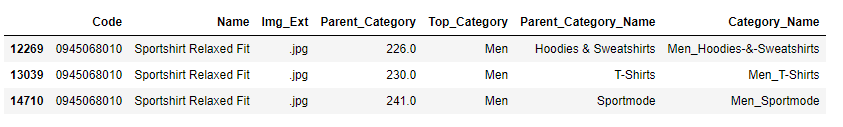

In [ ]:
# reading files again for sanity
cats = pd.read_parquet(hnm_file_format.format('Categories'))
items = pd.read_parquet(hnm_file_format.format('Items'))

In [ ]:
def apply_name(row):
    if math.isnan(row['Parent_Category_x']):
        return '_'.join([row['Top_Category_x'], row['Category_x'].replace(' ', '-')])
    else:
        return '_'.join([row['Top_Category_x'], row['Category_y'].replace(' ', '-'), row['Category_x'].replace(' ', '-')])

cats['Category_Name'] = cats.merge(
    cats[cats['Parent_Category'].isnull()], 
    right_index=True, 
    left_on='Parent_Category', 
    how='left'
).apply(apply_name, axis=1)

# adding top category name and parent category id
items = items.merge(
    cats[['Category', 'Parent_Category', 'Top_Category', 'Category_Name']], 
    how='left', 
    left_on='Category', 
    right_index=True
).drop(
    columns='Category_y'
).rename(
    columns={
        'Category_x': 'Category',
        'Category_Name': 'Sub_Category_Name'
    }
)

# adding name of parent category also
items = items.merge(
    cats[['Category', 'Parent_Category', 'Category_Name']], 
    left_on='Parent_Category', 
    right_index=True, 
    how='left'
).rename(
    columns={
        'Category_x': 'Category',
        'Category_y': 'Parent_Category_Name',
        'Parent_Category_x': 'Parent_Category'
}
).drop(
    columns='Parent_Category_y'
)

# Keeping only relevant columns and dropping the rest
items_u = items[['Code', 'Name', 'Img_Ext', 'Parent_Category', 'Top_Category', 'Parent_Category_Name', 'Category_Name']].drop_duplicates()

# let's drop these products and keep only those which have a unique category assigned to them
item_cnts = items_u['Code'].value_counts()
items_to_drop = list(item_cnts[item_cnts > 1].index)

items_u = items_u[~items_u['Code'].isin(items_to_drop)].copy()


items_u.head()

In [ ]:
items.groupby('Category_Name')['Code'].agg(['count', pd.Series.nunique])

In [ ]:
print(f"Final dataframe with {items_u.shape[0]:,} products across {items_u['Category_Name'].nunique()} categories")

In [93]:
# Saving the final dataframe - commented out since we dont need to run this again
# items_u.to_parquet(hnm_file_format.format('Final_Input_Df'))

### Data prep for Goal 2: Model Training for Filters Prediction

After creating the final list of items that we are including for modeling under Goal 1, I have restricted data prepration for Goal 2 also to only this set of items.

The base information with regards to different filters and the mapping to each item is available in the following 2 files:
1. Filters: Dataframe containing information on filters available in each sub-category eg. Colour, Pattern, Sleeve Length, etc.
1. Filter Values: Dataframe containing the Item code, the fitler Id and the value of the Filter for that item.

There are a totol of 20 Filters available across the target products. The fitlers and some sample values are given below (please note - the sample values are in German).

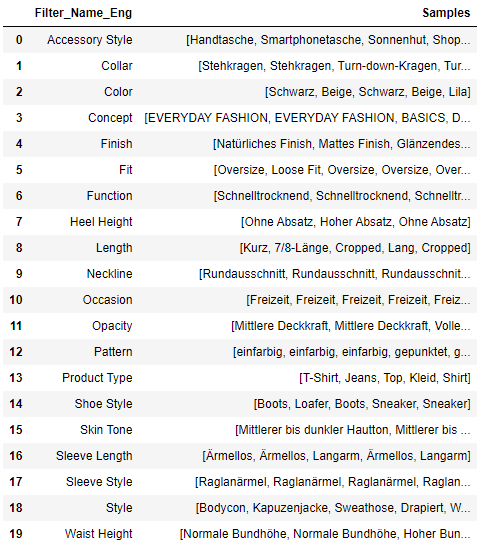

Each fitler can have different number of options. The count of options in each filter type is shown below:



The following data preparation steps have been conducted:

1. Keeping only the items which are also there in the data for Goal 1
1. Converting the names of the filters to English (from German) to enable easier exploration
1. For each item, I have created 2 one hot encoded lists:
    1. Product Filters => This is a one hot encoded vector of 20 values - "1" in case the product has a value assigned for that filter, "0" otherwise.
    1. Filter Values => This is a list of lists. Each row contains a list having 20 sub-lists. Each sub-list is a one-hot encoded vector having a length equal to the number of options for that filter - "1" in case that fitler value applies to the product, "0" otherwise.



In [ ]:
# reading required files again for sanity
filters = pd.read_parquet(hnm_file_format.format('Filters'))
attributes = pd.read_parquet(hnm_file_format.format('FilterAttributes'))

# Reading final data for Goal 1
final_df = pd.read_parquet(hnm_file_format.format('Final_Input_Df'))

In [ ]:
# Keeping only the items which are also there in the data for Goal 1
attribs = attributes[attributes['Code'].isin(final_df['Code'].unique())]

# merging information from filters dataframe back into the attribs dataframe - to have descriptive information available
attribs = attributes.merge(filters, left_on='Filter_ID', right_index=True, how='left')

attribs.head()

In [ ]:
# Extracting the actual value of the filter from the "list" in the Filter Option column
attribs['Filter_Option_Txt'] = attribs.apply(lambda row: row['Filter_Option'][0], axis=1)

# Performing a special step to convert the names of the filters to English (from German)
eng_convert = dict(zip(list(['Absatzhöhe', 'Accessoirestil', 'Anlass', 'Ausschnitt', 'Bundhöhe',
       'Deckkraft', 'Farbe', 'Finish', 'Funktion', 'Hautton', 'Konzept',
       'Kragen', 'Länge', 'MUSTER', 'Passform', 'Produkttyp', 'Schuhstil',
       'Style', 'Ärmellänge', 'Ärmelstil']), list([x.title() for x in 
    ['heel height', 'accessory style', 'occasion', 'neckline', 'waist height', 'Opacity', 'Color', 'Finish', 'Function', 'Skin Tone', 'Concept', 'collar', 'length', 'pattern', 'fit', 'product type', 'shoe style', 'style', 'sleeve length', 'sleeve style']
])))

attribs['Filter_Name_Eng'] = attribs.apply(lambda row: eng_convert[row['Filter_Name']], axis=1)

In [ ]:
# Starting prepration of final input dataframe for Filters
df_filters = final_df.copy()

# Adding "Product_Filters" => One hot encoded list of filters available on the product level
p_filters = attribs[['Code', 'Parent_Category', 'Filter_Name_Eng']].drop_duplicates(ignore_index=True)
p_filters['Val'] = 1
p_filters = p_filters.pivot(
    index=['Code', 'Parent_Category'], 
    columns='Filter_Name_Eng', 
    values='Val'
).fillna(0).reset_index()
p_filters['Filters'] = p_filters[filter_names].values.tolist()
df_filters = df_filters.merge(
    p_filters[['Code', 'Parent_Category', 'Filters']], 
    on=['Code', 'Parent_Category'], 
    how='left'
).rename(
    columns={'Filters': 'Product_Filters'}
)

# Adding one hot encoded vectors for each filter option
attribs['Filter_Value'] = attribs.apply(lambda row: f"{row['Filter_Name_Eng']}_{row['Filter_Option_Txt']}", axis=1)
final_filters = pd.DataFrame(df_filters['Code'].unique().copy())
final_filters.columns = ['Code']
attribs = attribs[attribs['Code'].isin(final_filters['Code'].values)]

filter_value_lists = []

for f in filter_names:
    filter_temp = pd.get_dummies(
        data=attribs[attribs['Filter_Name_Eng'] == f][['Code', 'Filter_Value']], 
        columns=['Filter_Value'],
        prefix='',
        prefix_sep=''
    )
    # get all unique codes with multi-labels
    filter_temp = filter_temp.groupby('Code').sum()
    # add the values to a list - we'll need this later when we're doing predictions
    filter_value_lists.append(filter_temp.columns.tolist())
    # compressing all codes into a list
    filter_temp[f] = filter_temp.values.tolist()
    # keeping only the code and the list
    filter_temp = filter_temp[f].reset_index()
    # merging the list back into the master df
    final_filters = final_filters.merge(filter_temp, on='Code', how='left')
    # setting all null values to an empty list
    final_filters[f] = final_filters[f].apply(lambda d: d if isinstance(d, list) else [])

final_filters['Filter_Values'] = final_filters[filter_names].values.tolist()

df_filters = df_filters.merge(final_filters[['Code', 'Filter_Values']], on='Code', how='left')


In [ ]:
# # Saving the various files => Commented out since this is already completed!
# # saving the filters file
# df_filters.to_parquet(hnm_file_format.format('Final_Input_Filters'))

# # save the list files as a pickle file
# with open('data/HnM_FilterValueLists.pkl', 'wb') as file_pi:
#     pickle.dump(filter_value_lists, file_pi)

Loading the final dataframe

In [7]:
## load the data frame
df = pd.read_parquet(hnm_file_format.format('Final_Input_Df'))
df['Category_Name'] = df['Category_Name'].astype('category')
df['Category_Name_Code'] = df['Category_Name'].cat.codes

In [8]:
# sort by the code
df = df.sort_values(by='Code')
df.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Name_Code
9842,0107727001,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9844,0107727002,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9839,0107727021,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9832,0107727061,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9837,0107727062,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23


In [10]:
# adding image paths into the df directly
df['image_paths'] = df.apply(lambda row: f"{hnm_img_resized}{row['Code']}{row['Img_Ext']}", axis=1)

In [12]:
# separating a test set
df_train, df_test = train_test_split(df, train_size=0.9, random_state=25)

In [13]:
# keeping train and validation separate
df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=25)

Setting up a DF for categories to track results

In [16]:
cats = df[['Category_Name_Code', 'Category_Name']].drop_duplicates().sort_values(by='Category_Name_Code').reset_index(drop=True)
cats.head()

,Category_Name_Code,Category_Name
0,0,Baby_Accessoires
1,1,Baby_Kleidung
2,2,Kids_Accessoires
3,3,Kids_Kleidung
4,4,Kids_Outdoor


In [17]:
cats['Cnt_Products'] = df.groupby('Category_Name_Code')['Code'].count()
cats.head()

,Category_Name_Code,Category_Name,Cnt_Products
0,0,Baby_Accessoires,123
1,1,Baby_Kleidung,1058
2,2,Kids_Accessoires,286
3,3,Kids_Kleidung,4237
4,4,Kids_Outdoor,268


Getting CnA data as a another test set

In [14]:
# load the dataframe
df_cna = pd.read_parquet(cna_file_format.format('Final_Df_Test'))

In [18]:
# get category codes
df_cna = df_cna.merge(cats[['Category_Name_Code', 'Category_Name']], how='left', left_on='Cat_Name_Mapped', right_on='Category_Name')

# get img filenames
df_cna['image_paths'] = df_cna.apply(lambda row: f"{cna_img_resized}{row['Code']}{row['Img_Ext']}", axis=1)

df_cna.head()

,Code,Name,URL,Img_URL,Img_Ext,Category,Parent_Category,Cat_Name_Mapped,Category_Name_Code,Category_Name,image_paths
0,2158240_1,CLOCKHOUSE - Kleid - kariert,https://www.c-and-a.com/de/de/shop/clockhouse-...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,75.0,2.0,Women_Kleider,22,Women_Kleider,images_test_resized/CnA_{}{}2158240_1.jpg
1,2173987_2,CLOCKHOUSE - Kleid - geblümt,https://www.c-and-a.com/de/de/shop/clockhouse-...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,75.0,2.0,Women_Kleider,22,Women_Kleider,images_test_resized/CnA_{}{}2173987_2.jpg
2,2165021_2,Strickkleid,https://www.c-and-a.com/de/de/shop/strickkleid...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,73.0,2.0,Women_Kleider,22,Women_Kleider,images_test_resized/CnA_{}{}2165021_2.jpg
3,2155417_1,Kleid,https://www.c-and-a.com/de/de/shop/kleid-21554...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,81.0,2.0,Women_Kleider,22,Women_Kleider,images_test_resized/CnA_{}{}2155417_1.jpg
4,2130669_1,Strickkleid,https://www.c-and-a.com/de/de/shop/strickkleid...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,73.0,2.0,Women_Kleider,22,Women_Kleider,images_test_resized/CnA_{}{}2130669_1.jpg


Setting up helper functions and variables

In [34]:
img_shape = (224, 224, 3)
batch_size = 128

metric_acc_key, metric_v_acc_key, metric_v_topk_acc_key = ('cat_acc', 'val_cat_acc', 'val_top3_cat_acc')

In [20]:
def generate_datasets(model_params, img_paths, labels = None, product_filters = None, filter_values = None, seed=25, batch_size=batch_size, 
                    image_size=img_shape[:2], num_channels=3, interpolation='bilinear', crop_to_aspect_ratio=False,
                    shuffle=True):
    """
        Sub-function to return a data set given a list of image paths and associated labels + addl information
        
        :param image_paths: paths to images
        :param labels: list of associated labels for each img
        :param cat_inputs: np array with cat_inputs for each img
        
        length of all inputs should be same as nr of images in directory
        
    """

    # generate dataset
    path_ds = tf.data.Dataset.from_tensor_slices(img_paths)
    args = (image_size, num_channels, interpolation, crop_to_aspect_ratio)
    img_ds = path_ds.map(
      lambda x: image_dataset.load_image(x, *args), num_parallel_calls=tf.data.AUTOTUNE
    )

    if model_params.get('concat', False):
        # concatenation of equalized images, load equalized images separately
        img_eq_ds = img_ds.map(lambda x: tfa.image.equalize(x), num_parallel_calls=AUTOTUNE)
        img_ds = tf.data.Dataset.zip((img_ds, img_eq_ds))
    elif model_params.get('equalize', False):
        # equalize the source image
        img_ds = img_ds.map(lambda x: tfa.image.equalize(x), num_parallel_calls=AUTOTUNE)

    # prod_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(product_filters))
    if labels is None:
        prod_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(np.concatenate(product_filters).reshape(-1, 20)))

        filt_ds = []
        for i, size in enumerate(out_size):
            vals = np.concatenate(filter_values[:, i]).reshape(-1, size)
            filt_ds.append(
                tf.data.Dataset.from_tensor_slices(vals)
            )

        # filt_ds = tuple(tf.data.Dataset.from_tensor_slices(tf.ragged.constant(f)) for f in filter_values)
        filt_ds = tf.data.Dataset.zip(tuple(f for f in filt_ds))

        inputs_ds = tf.data.Dataset.zip((img_ds, prod_ds))
        img_ds = tf.data.Dataset.zip((inputs_ds, filt_ds))
    else:
        labels_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(labels))

        img_ds = tf.data.Dataset.zip((img_ds, labels_ds))

    
    if shuffle:
        img_ds = img_ds.shuffle(buffer_size=batch_size * 8, seed=seed)
    img_ds = img_ds.batch(batch_size)
    return img_ds
    

In [21]:
def make_gradcam_heatmap(imgs, model, last_conv_layer_name, pred_index=None):
    """
        Output the gradcam heatmap
        
        :param imgs: Tf.Dataset that gives the output as expected by the model input
        :param model: The actual model to be used for constructing Gradcam
        :param last_conv_layer_name: The name of the layer which should be used to generate heatmap
    """
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [
            model.get_layer(last_conv_layer_name).output, 
            model.output
        ]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
        
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(imgs)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img, heatmap, ax, alpha=0.4):
    """
        Displays the original image and the heatmap on top of it as an overlap
    """
    # Load the original image
    # img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
#     superimposed_img.save(cam_path)

    # Display Grad CAM
    ax.imshow(superimposed_img)

In [27]:
def create_model(model_name, model_params, load_wts = False):
    base_model = eval('tf.keras.applications.' + model_params['model'])(
        include_top=False, 
        input_shape=img_shape, 
        pooling=model_params.get('model_pooling', 'max')
    )

    x = base_model.output

    inputs = base_model.input

    if model_params.get('concat', False):
        # expect 2 inputs -> regular image and equalized image
        eq_model = eval('tf.keras.applications.' + model_params['model'])(include_top=False, input_shape=input_shape, pooling=model_params.get('model_pooling', 'max'))
        y = eq_model.output

        # change the names of the layers
        # else weights dont get saved properly
        for l in eq_model.layers:
            l._name = l.name + '_eq'

        x = Concatenate()([x, y])
        inputs = [base_model.input, eq_model.input]

    # let's add a fully-connected layers
    for _ in range(model_params['dense_layers']):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    # and a logistic layer -- with classes = nr_labels
    predictions = Dense(nr_labels, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=inputs, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(
        optimizer=Adam(learning_rate=model_params.get('learning_rate', 1e-4)), 
        loss='sparse_categorical_crossentropy', 
        metrics=[SparseCategoricalAccuracy(name='cat_acc'), SparseTopKCategoricalAccuracy(k=3, name='top3_cat_acc')]
    )

    if load_wts:
        model.load_weights(f"{model_wts_path}{model_name}.h5")

    return model

In [31]:
def run_models(models):
    
    model_hists = {}
    for model_name, model_params in models.items():
        K.clear_session()
        if os.path.exists(f"{model_hist_path}{model_name}.pkl"):
            with open(f"{model_hist_path}{model_name}.pkl", 'rb') as file_pi:
                model_hists[model_name] = pickle.load(file_pi)
            # we've completed this one... let's keep going
            print(f"{model_params['desc']} already trained. Loading history from pickle file.")
            continue

        print(f"Starting training with {model_name}")
        model = create_model(model_name, model_params)

        images_train = generate_datasets(
            model_params,
            df_train['image_paths'].values,
            labels=df_train['Category_Name_Code'].values,
            batch_size=model_params.get('batch_size', batch_size)
        )
        images_val = generate_datasets(
            model_params,
            df_val['image_paths'].values,
            labels=df_val['Category_Name_Code'].values,
            batch_size=model_params.get('batch_size', batch_size)
        )

        images_train_f = images_train.prefetch(1)
        images_val_f = images_val.prefetch(1)

        print(f"All ready! Starting fit!")
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=model_params.get('patience', 10), 
            restore_best_weights=True, 
            min_delta=model_params.get('min_delta', 0.01), 
            verbose=1
        )

        # model.summary()
        hist = model.fit(
            images_train_f,
            batch_size=model_params.get('batch_size', batch_size),
            epochs=model_params['epochs'],
            validation_data=images_val_f,
            verbose=True,
            callbacks=[es],
        )

        model.save_weights(f"{model_wts_path}{model_name}.h5")

        min_loss_idx = np.argmin(hist.history['val_loss'])

        model_hists[model_name] = hist
        with open(f"{model_hist_path}{model_name}.pkl", 'wb') as file_pi:
            pickle.dump(hist.history, file_pi)

        print(f"Completed training of {model_name} with max validation accuracy: {hist.history[metric_v_acc_key][min_loss_idx]:.2%} at Epoch Nr {min_loss_idx+1}")

    return model_hists

In [ ]:
# get_metric_keys = lambda hist: ('cat_acc', 'val_cat_acc', 'val_top3_cat_acc') if 'cat_acc' in hist else ('sparse_categorical_accuracy', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy')

Starting training: Transfer learning section

In [25]:
models = {
    'S1_DenseNet121': {
        'model': 'DenseNet121',
        'preprocess': 'densenet',
        'dense_layers': 2,
        'epochs': 5,
        'learning_rate': 1e-2,
        'model_pooling': 'max',
        'desc': 'DenseNet121',
    },
    'S1_VGG19': {
        'model': 'VGG19',
        'preprocess': 'vgg19',
        'dense_layers': 2,
        'epochs': 5,
        'learning_rate': 1e-2,
        'model_pooling': 'max',
        'desc': 'VGG19',
    },
    'S1_Resnet50': {
        'model': 'ResNet50V2',
        'preprocess': 'resnet_v2', # need these separately since module name of preprocess methods are different
        'dense_layers': 2,
        'epochs': 5,
        'learning_rate': 1e-2,
        'model_pooling': 'max',
        'desc': 'Resnet50',
    },
    'S1_InceptionV3': {
        'model': 'InceptionV3',
        'preprocess': 'inception_v3',
        'dense_layers': 2,
        'epochs': 5,
        'learning_rate': 1e-2,
        'model_pooling': 'max',
        'desc': 'InceptionV3',
    },
    'S1_MobileNetV2': {
        'model': 'MobileNetV2',
        'preprocess': 'mobilenet_v2',
        'dense_layers': 2,
        'epochs': 5,
        'learning_rate': 1e-2,
        'model_pooling': 'max',
        'desc': 'MobileNetV2',
    },
    'S1_EfficientNetB3': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
        'dense_layers': 2,
        'epochs': 5,
        'learning_rate': 1e-2,
        'model_pooling': 'max',
        'desc': 'EfficientNetB3',
    },
}

In [32]:
model_hists = run_models(models)

DenseNet121 already trained. Loading history from pickle file.
VGG19 already trained. Loading history from pickle file.
Resnet50 already trained. Loading history from pickle file.
InceptionV3 already trained. Loading history from pickle file.
MobileNetV2 already trained. Loading history from pickle file.
EfficientNetB3 already trained. Loading history from pickle file.


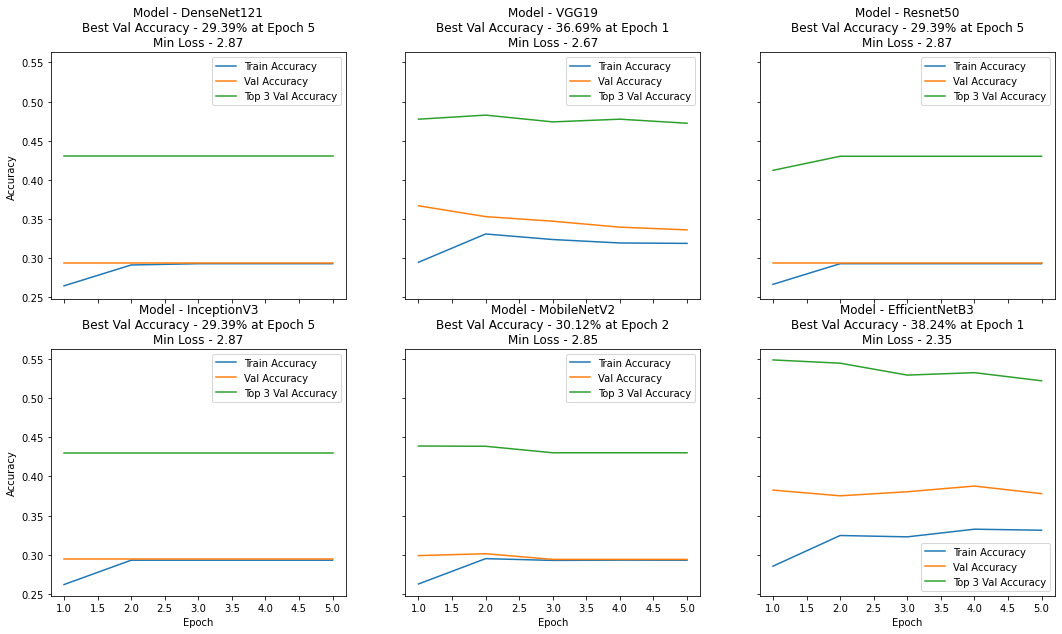

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.ravel()

for idx, model in enumerate(models.keys()):
    with open(f"{model_hist_path}{model}.pkl", 'rb') as file_pi:
        hist = pickle.load(file_pi)

    best_epoch = np.argmin(hist['val_loss'])

    sns.lineplot(x=range(1, len(hist[metric_acc_key]) + 1 ), y=hist[metric_acc_key], ax=axes[idx], label='Train Accuracy')
    sns.lineplot(x=range(1, len(hist[metric_v_acc_key]) + 1 ), y=hist[metric_v_acc_key], ax=axes[idx], label='Val Accuracy')
    sns.lineplot(x=range(1, len(hist[metric_v_topk_acc_key]) + 1 ), y=hist[metric_v_topk_acc_key], ax=axes[idx], label='Top 3 Val Accuracy')

    axes[idx].set(
        title=f"Model - {models[model]['desc']}\nBest Val Accuracy - {hist[metric_v_acc_key][best_epoch]:.2%} at Epoch {best_epoch+1}\nMin Loss - {hist['val_loss'][best_epoch]:.2f}",
        xlabel="Epoch",
        ylabel="Accuracy"
    )

    # axes[idx].axvline(x=best_epoch+1, color='red')

# axes[3].axis('off')

plt.show()

Choosing Efficient Net B3 since it has the lowest loss

Stage 2: Different model architectures with Efficient Net B3

In [41]:
models = {
    'S2_ENetB3_Exp_2D_500E': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
        'model_pooling': 'max',
        'epochs': 500,
        'learning_rate': 1e-4,
        'dense_layers': 2,
        'patience': 25,
        'min_delta': 0.01,
        'desc': 'CNN->FCNN; Depth: 2',
    },
    'S2_ENetB3_Exp_5D_500E': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
        'model_pooling': 'max',
        'epochs': 500,
        'learning_rate': 1e-4,
        'dense_layers': 5,
        'patience': 20,
        'min_delta': 0.01,
        'desc': 'CNN->FCNN; Depth: 5',
    },
#     'S2_ENetB3_Exp_2D_500E_Eq': {
#         'model': 'EfficientNetB3',
#         'preprocess': 'efficientnet',
#         'model_pooling': 'max',
#         'epochs': 500,
#         'learning_rate': 1e-4,
#         'dense_layers': 2,
#         'patience': 5,
#         'min_delta': 0.01,
#         'equalize': True,
#         'desc': 'CNN->FCNN; Depth: 2; Equalized Inputs',
#     },
    'S2_ENetB3_Exp_2D_500E_Eq_Concat': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
        'model_pooling': 'max',
        'epochs': 500,
        'learning_rate': 1e-4,
        'dense_layers': 2,
        'patience': 5,
        'min_delta': 0.01,
        'equalize': True,
        'concat': True,
        'batch_size': 64,
        'desc': 'CNN->FCNN; Depth: 2; Both Inputs (Normal & Eq) - Concatenated',
    },
}

In [42]:
model_hists = run_models(models)

CNN->FCNN; Depth: 2 already trained. Loading history from pickle file.
CNN->FCNN; Depth: 5 already trained. Loading history from pickle file.
CNN->FCNN; Depth: 2; Both Inputs (Normal & Eq) - Concatenated already trained. Loading history from pickle file.


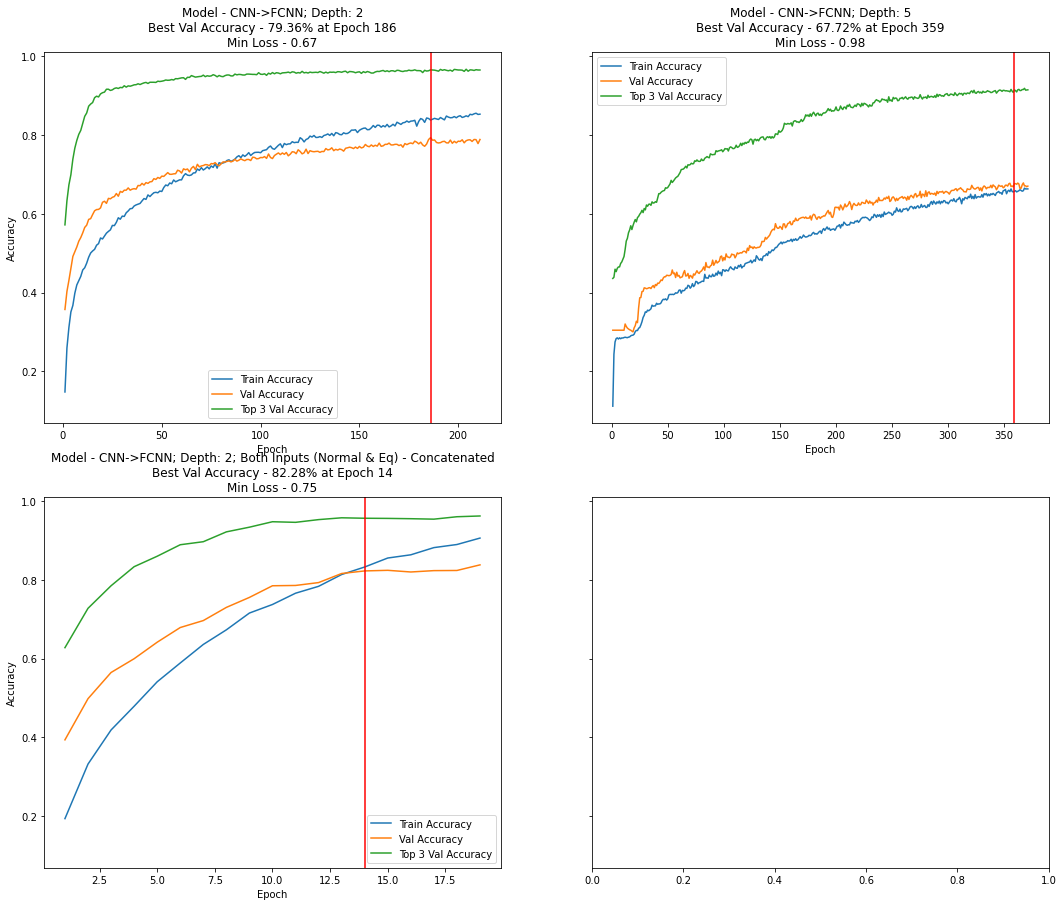

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15), sharey=True)
axes = axes.ravel()

for idx, model in enumerate(models.keys()):
    with open(f"{model_hist_path}{model}.pkl", 'rb') as file_pi:
        hist = pickle.load(file_pi)

    best_epoch = np.argmin(hist['val_loss'])

    sns.lineplot(x=range(1, len(hist[metric_acc_key]) + 1 ), y=hist[metric_acc_key], ax=axes[idx], label='Train Accuracy')
    sns.lineplot(x=range(1, len(hist[metric_v_acc_key]) + 1 ), y=hist[metric_v_acc_key], ax=axes[idx], label='Val Accuracy')
    sns.lineplot(x=range(1, len(hist[metric_v_topk_acc_key]) + 1 ), y=hist[metric_v_topk_acc_key], ax=axes[idx], label='Top 3 Val Accuracy')

    axes[idx].set(
        title=f"Model - {models[model]['desc']}\nBest Val Accuracy - {hist[metric_v_acc_key][best_epoch]:.2%} at Epoch {best_epoch+1}\nMin Loss - {hist['val_loss'][best_epoch]:.2f}",
        xlabel="Epoch",
        ylabel="Accuracy"
    )

    axes[idx].axvline(x=best_epoch+1, color='red')

plt.show()